## Importations

In [1]:
## for plotting figures :
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
sys.path.append('../')

##
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd

## util functions :
from scripts.machine_learning_utils import *
from scripts.manage_data import *
from scripts.descriptors import *

rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [73]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_OCO = df_total[df_total.group == 'OCO']
df_ONO = df_total[df_total.group == 'ONO']
df_NNN = df_total[df_total.group == 'NNN']
df_triarylboranes = df_total[df_total.group == "triarylboranes"]

In [31]:
## Import quantum descriptors
df_atom1 = pd.read_csv('../tables/descriptors/df_atom1_ext.csv').set_index("can")
df_global = pd.read_csv('../tables/descriptors/df_global_ext.csv').set_index("can")

data_Q_tot = {}

data_Q_tot['global']=df_global

data_Q_tot['atom1']=df_atom1

### Database cleaning

The goal of representation is also to identify outliers and remove them from the database

In [7]:
X = create_descriptors(df_total.index, "quantum", data = data_Q_tot)

In [4]:
names = get_names("quantum")

In [8]:
df_quantum = pd.DataFrame(X, columns = names)

In [18]:
df_quantum[df_quantum.converged != 1.0]

Empty DataFrame
Columns: [E, ES_root_dipole, ES_root_electronic_spatial_extent, ES_root_molar_volume, E_scf, E_thermal_correction, E_zpe, G, G_thermal_correction, H, H_thermal_correction, charge, converged, dipole, electronegativity, electronic_spatial_extent, hardness, homo_energy, lumo_energy, molar_mass, molar_volume, multiplicity, number_of_atoms, zero_point_correction, APT_charge, ES_root_Mulliken_charge, ES_root_NPA_Rydberg, ES_root_NPA_charge, ES_root_NPA_core, ES_root_NPA_total, ES_root_NPA_valence, Mulliken_charge, NMR_anisotropy, NMR_shift, NPA_Rydberg, NPA_charge, NPA_core, NPA_total, NPA_valence, VBur, X, Y, Z]
Index: []

[0 rows x 43 columns]

### 4 molecular structures representation

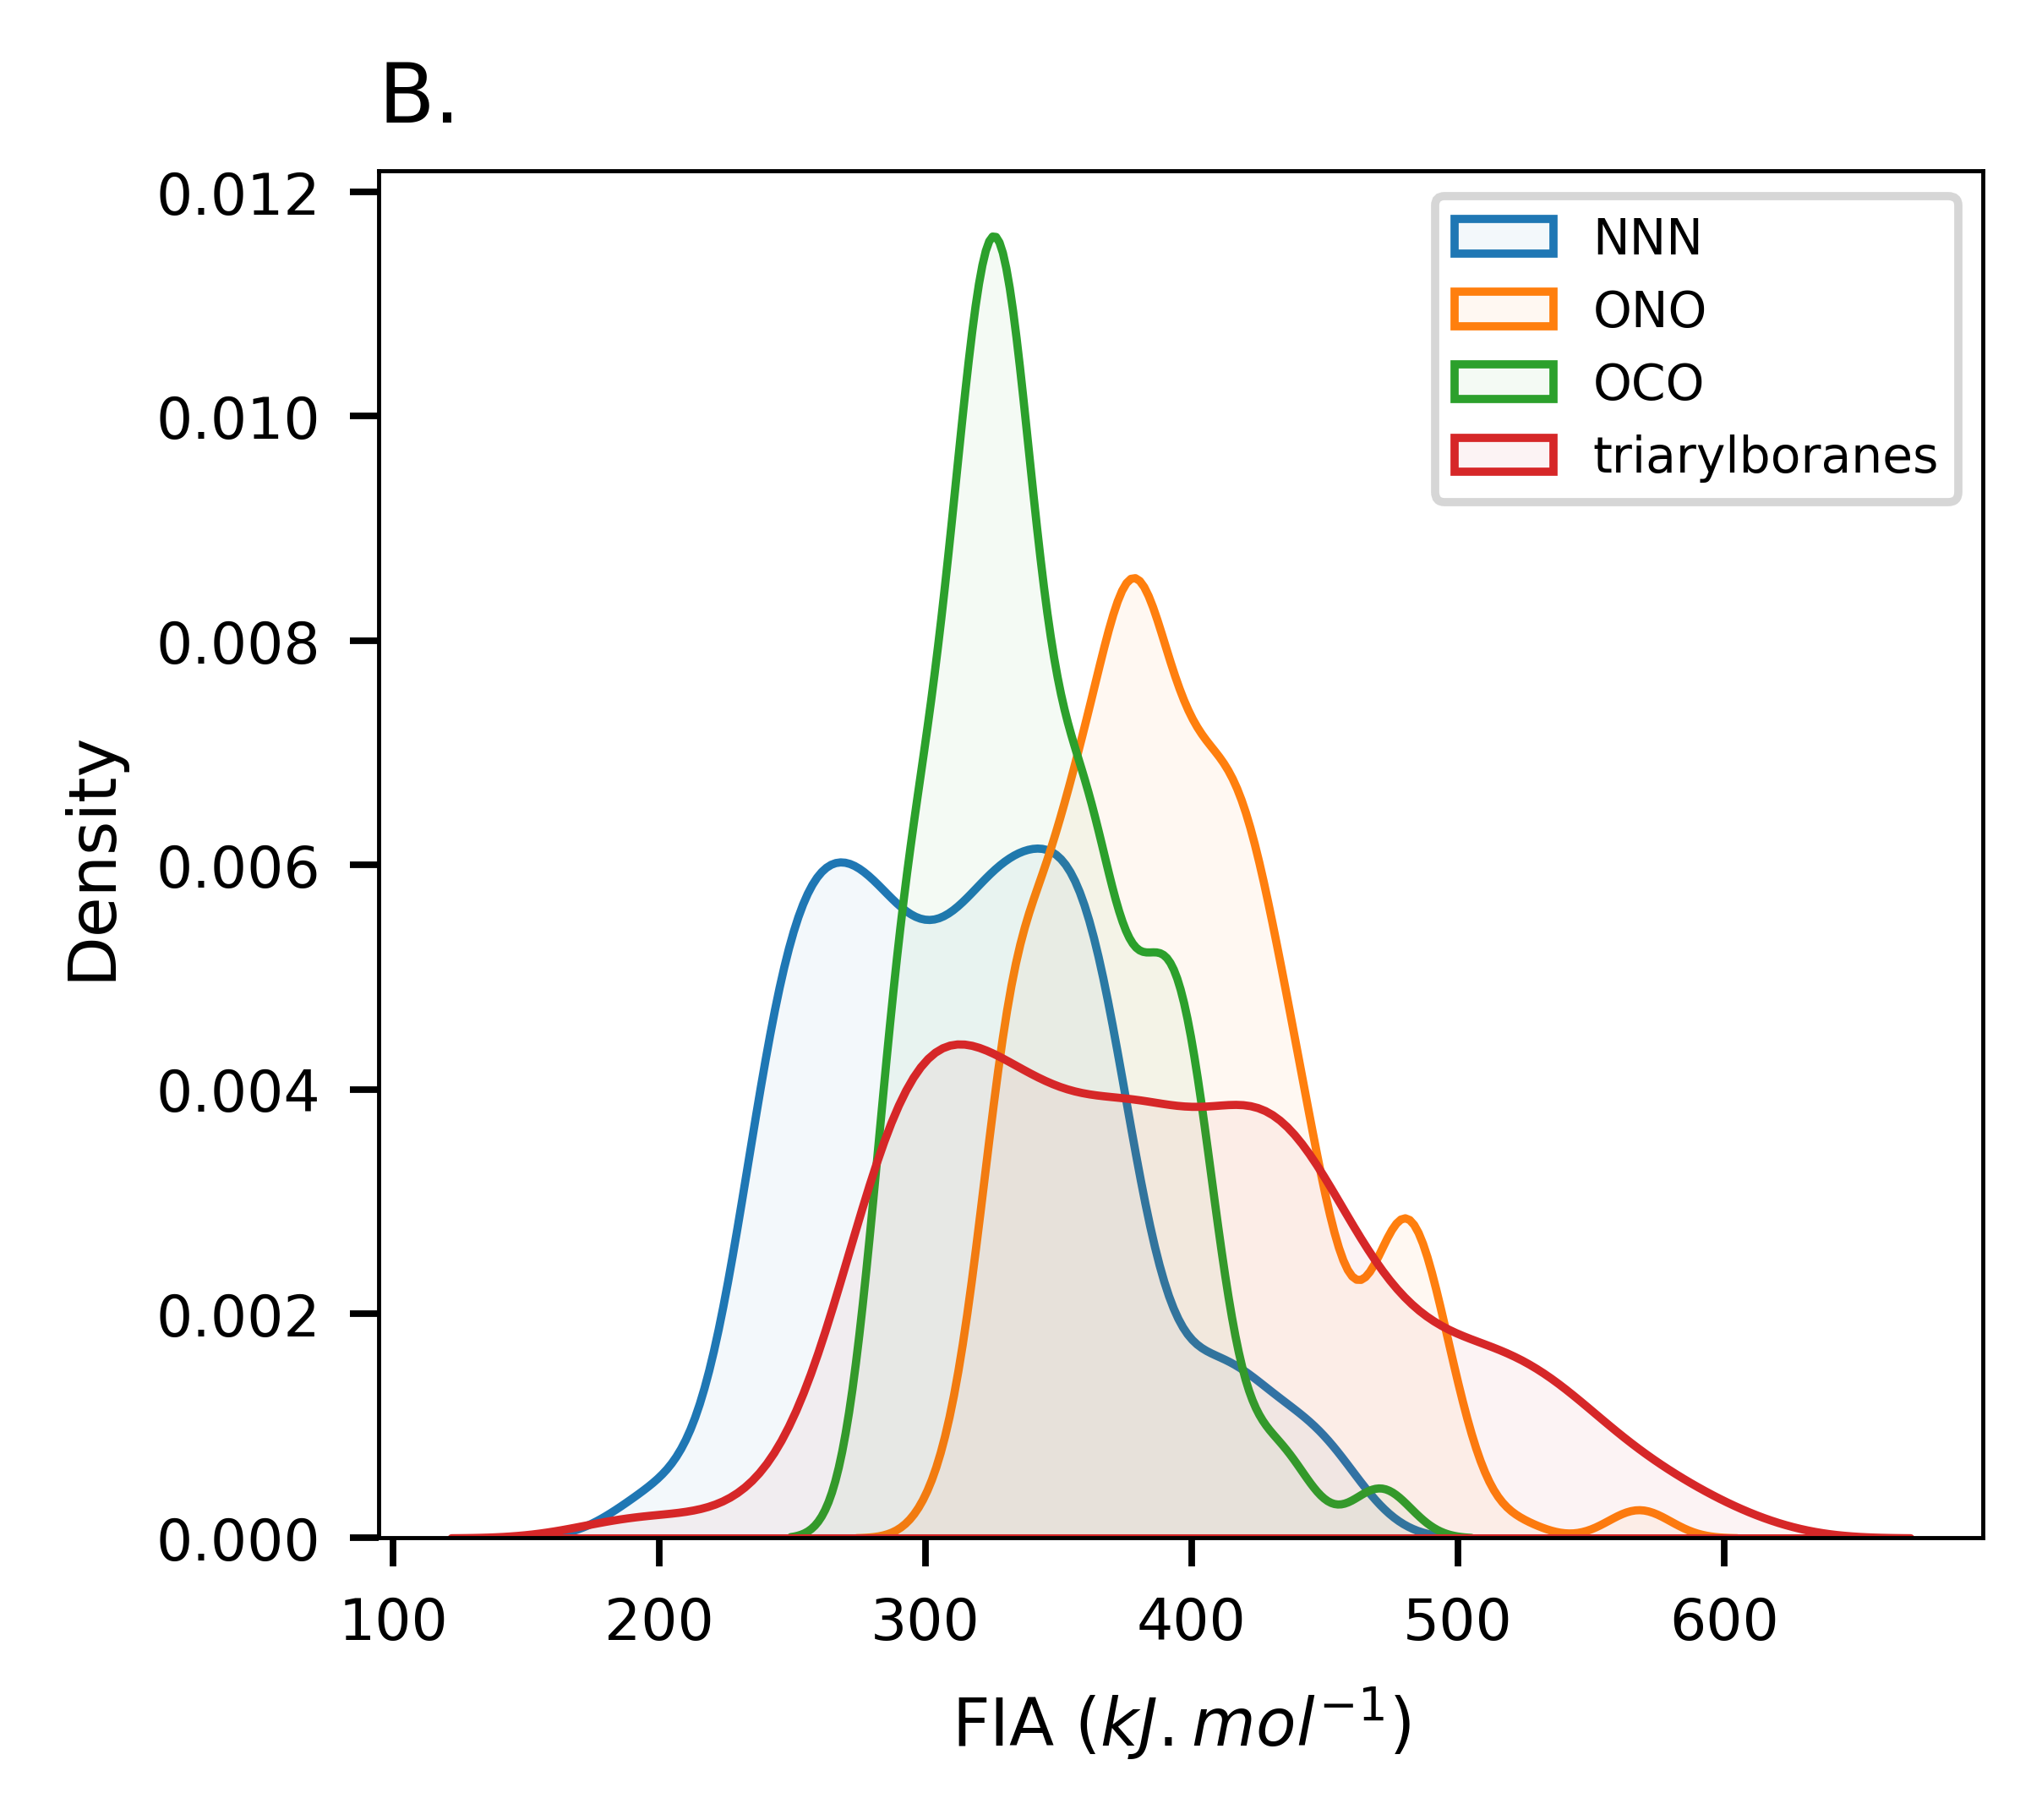

In [69]:
#sns.displot(df_total, x="FIA", kind ='kde', bw_adjust = 0.7, hue = 'group')
fig = plt.figure(figsize=(3.5, 3))

ax = fig.add_subplot()


bandwidth = 0.7
sns.kdeplot(df_total[df_total.group == 'NNN'], x="FIA", bw_adjust = bandwidth, label = 'NNN', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_total[df_total.group == 'ONO'], x="FIA", bw_adjust = bandwidth, label = 'ONO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_total[df_total.group == 'OCO'], x="FIA", bw_adjust = bandwidth, label = 'OCO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_total[df_total.group == 'triarylboranes'], x="FIA", bw_adjust = bandwidth, label = 'triarylboranes', fill =True, alpha=0.05, ax = ax)

ax.set_xlabel('FIA ($kJ.mol^{-1}$)')
ax.legend()
ax.set_title('B.', loc='left', fontsize =10)

fig.savefig('../results/chemical_space/DB_distributions.svg', format='svg', transparent= True, facecolor='white', bbox_inches='tight')



To represent distribution taking into account relative proportion of each molecular structure

In [ ]:
sns.displot(df_total, x="FIA", kind ='kde', bw_adjust = 0.7, hue = 'group')

qq-plot to check that the distribution is normal

<Figure size 2450x2100 with 0 Axes>

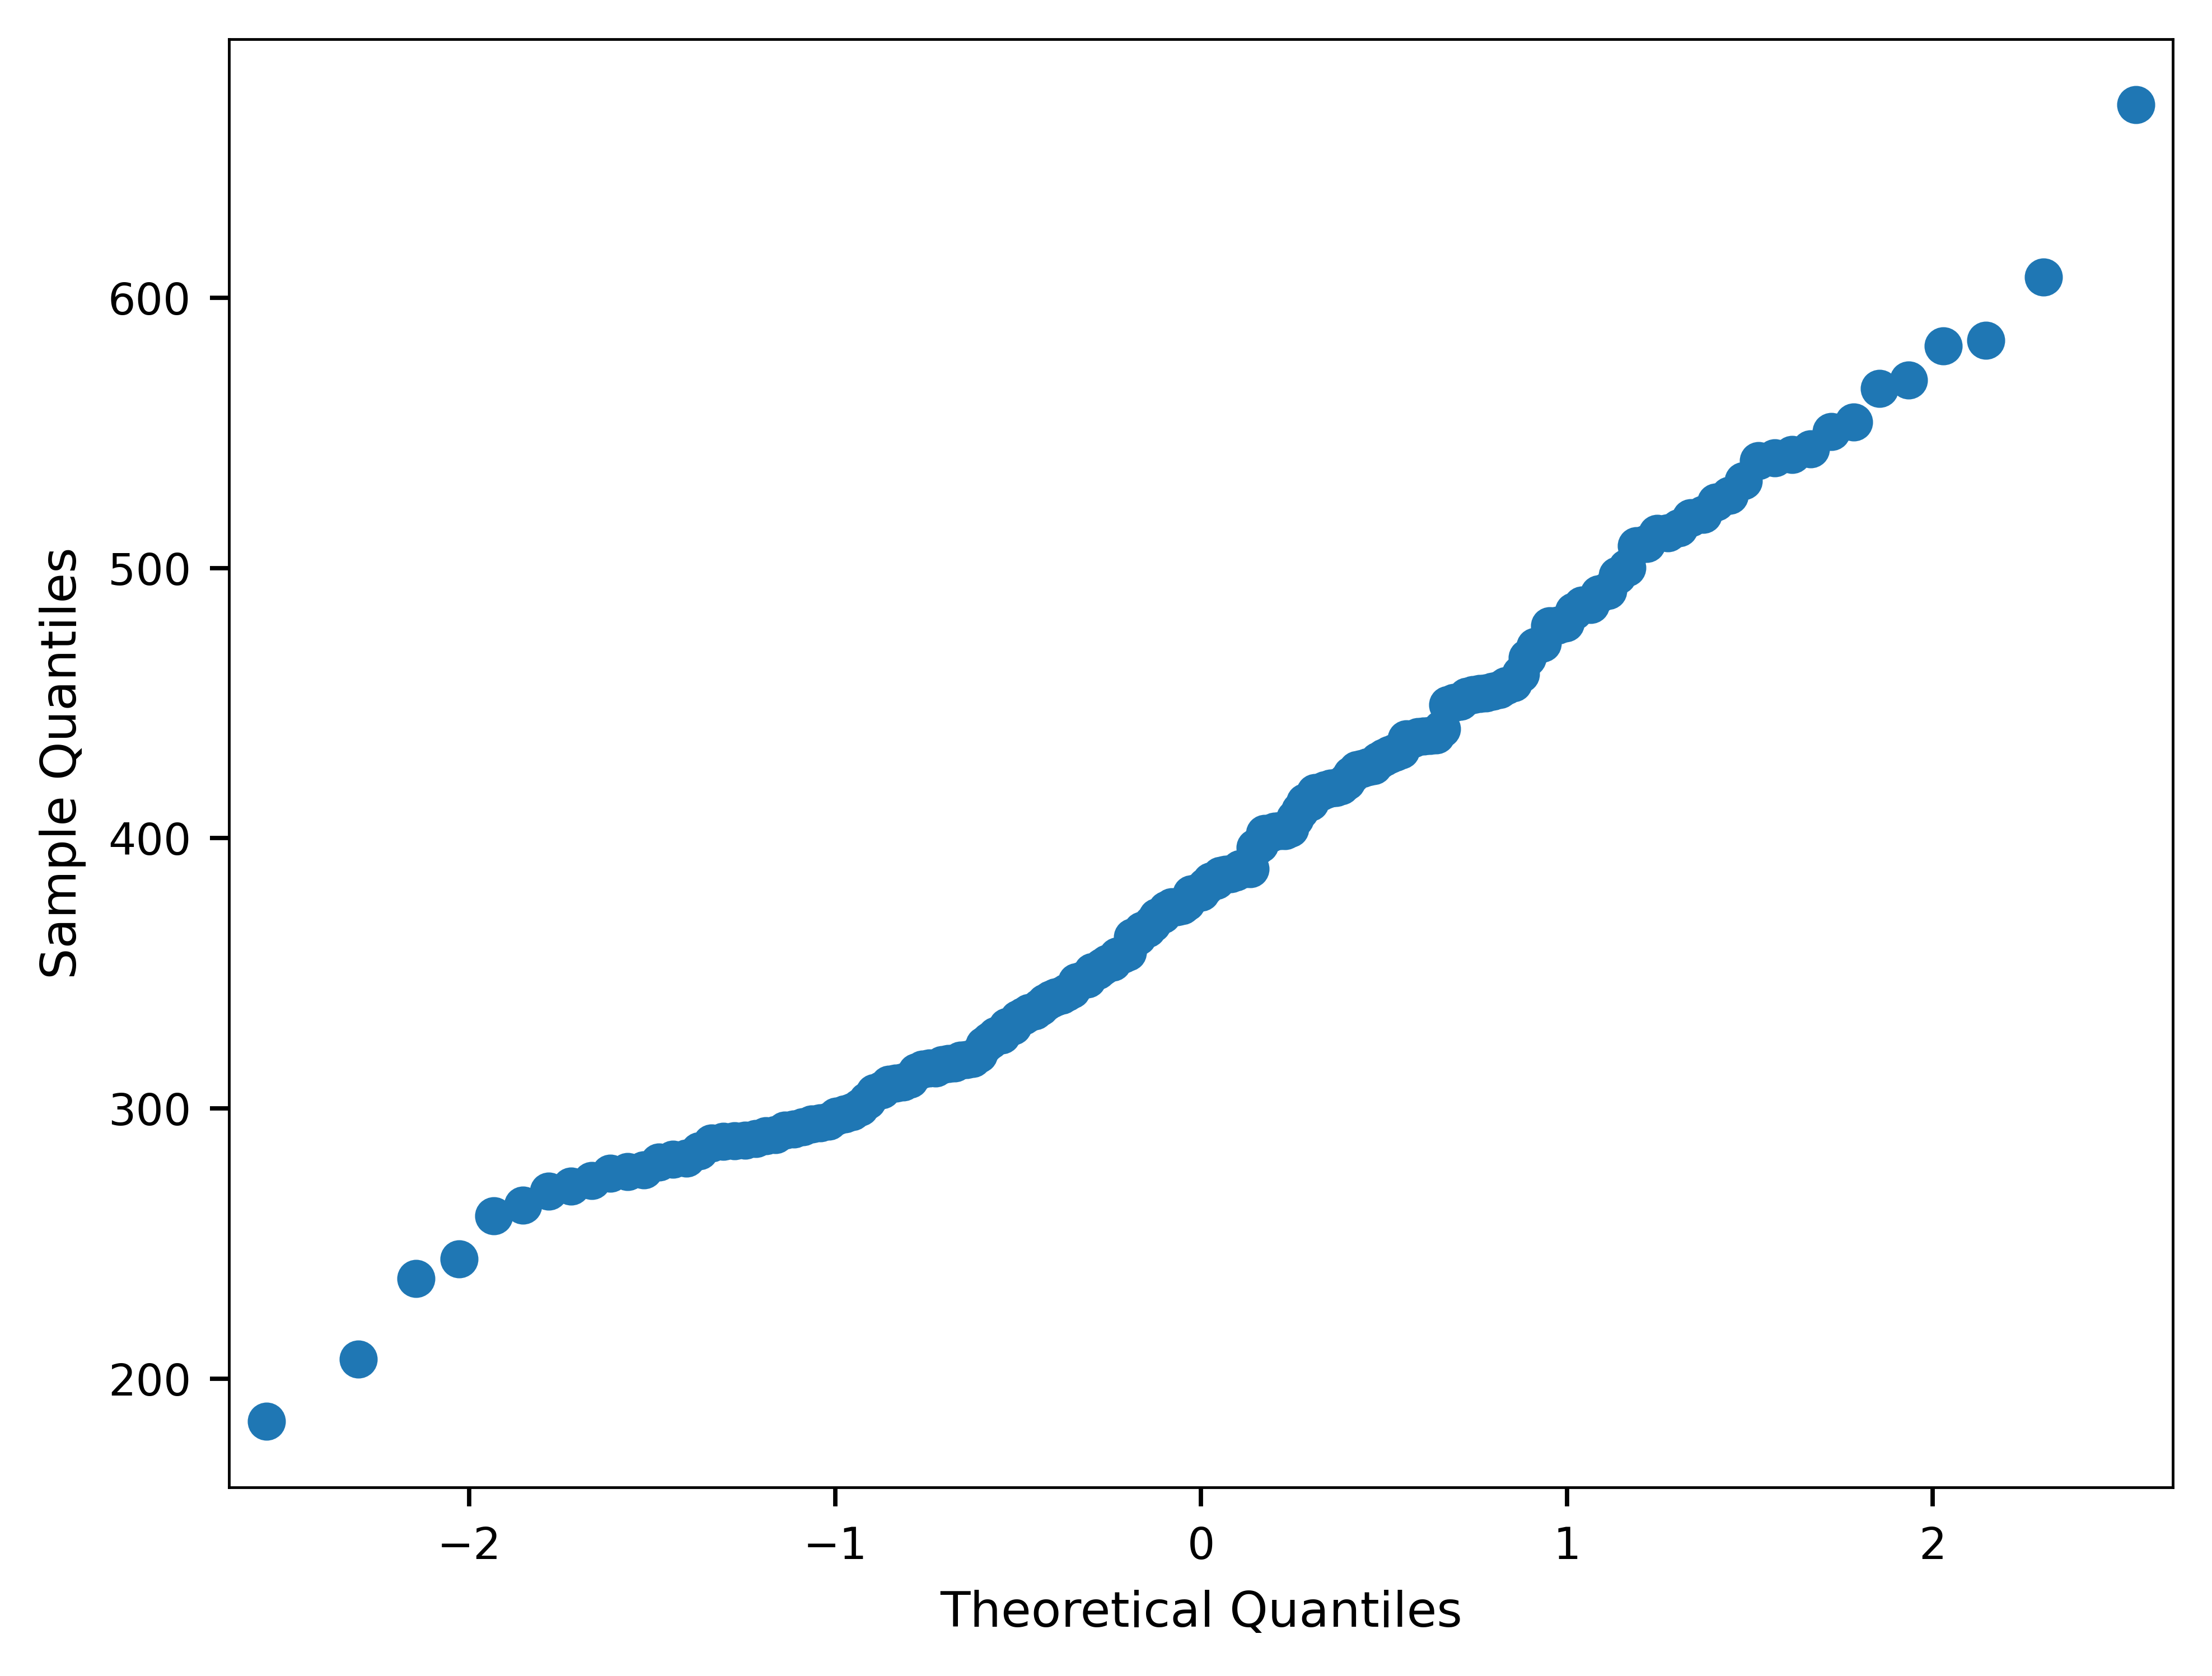

In [13]:
fig = plt.figure(figsize=(3.5, 3))
sm.qqplot(df_triarylboranes.FIA) ;

## Database extension for the ONO molecules

In [79]:
from sklearn.manifold import TSNE
df_X_all_fp = pd.read_csv('../tables/descriptors/X_fp_all_smiles_possible_ONO.csv').set_index('Unnamed: 0')
df_all_smiles = pd.read_csv('../tables/data/all_possible_smiles_FIA_ONO.csv').set_index('SMILES')

df_ONO_groups = pd.read_csv('../tables/data/smiles_FIA_ONO_extended_groups.csv').set_index('SMILES')
df_ONO_groups = df_ONO_groups.drop('N#Cc1c2c(cc(C(F)(F)F)c1C(F)(F)F)N1B(O2)Oc2c1cc(C(F)(F)F)c(C(F)(F)F)c2C#N')

In [80]:
X_all_fp = np.array(df_X_all_fp)

In [81]:
indexes_original = []
indexes_coverage = []
indexes_kmeans = []
for i, smi in enumerate(df_all_smiles.index) :
    if smi in df_ONO_groups[df_ONO_groups.group == 'original'].index :
        indexes_original.append(i)
    elif smi in df_ONO_groups[df_ONO_groups.group == 'kmeans'].index :
        indexes_kmeans.append(i)
    elif smi in df_ONO_groups[df_ONO_groups.group == 'kmeans & coverage'].index:
        indexes_kmeans.append(i)
        indexes_coverage.append(i)
    elif smi in df_ONO_groups[df_ONO_groups.group == 'coverage'].index :
        indexes_coverage.append(i)

In [82]:
X_embedded_all = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(X_all_fp)

In [83]:
df_X_embedded_all = pd.DataFrame(X_embedded_all)
df_X_embedded_random = df_X_embedded_all.loc[indexes_original]
df_X_embedded_kmeans = df_X_embedded_all.loc[indexes_kmeans]
df_X_embedded_coverage = df_X_embedded_all.loc[indexes_coverage]

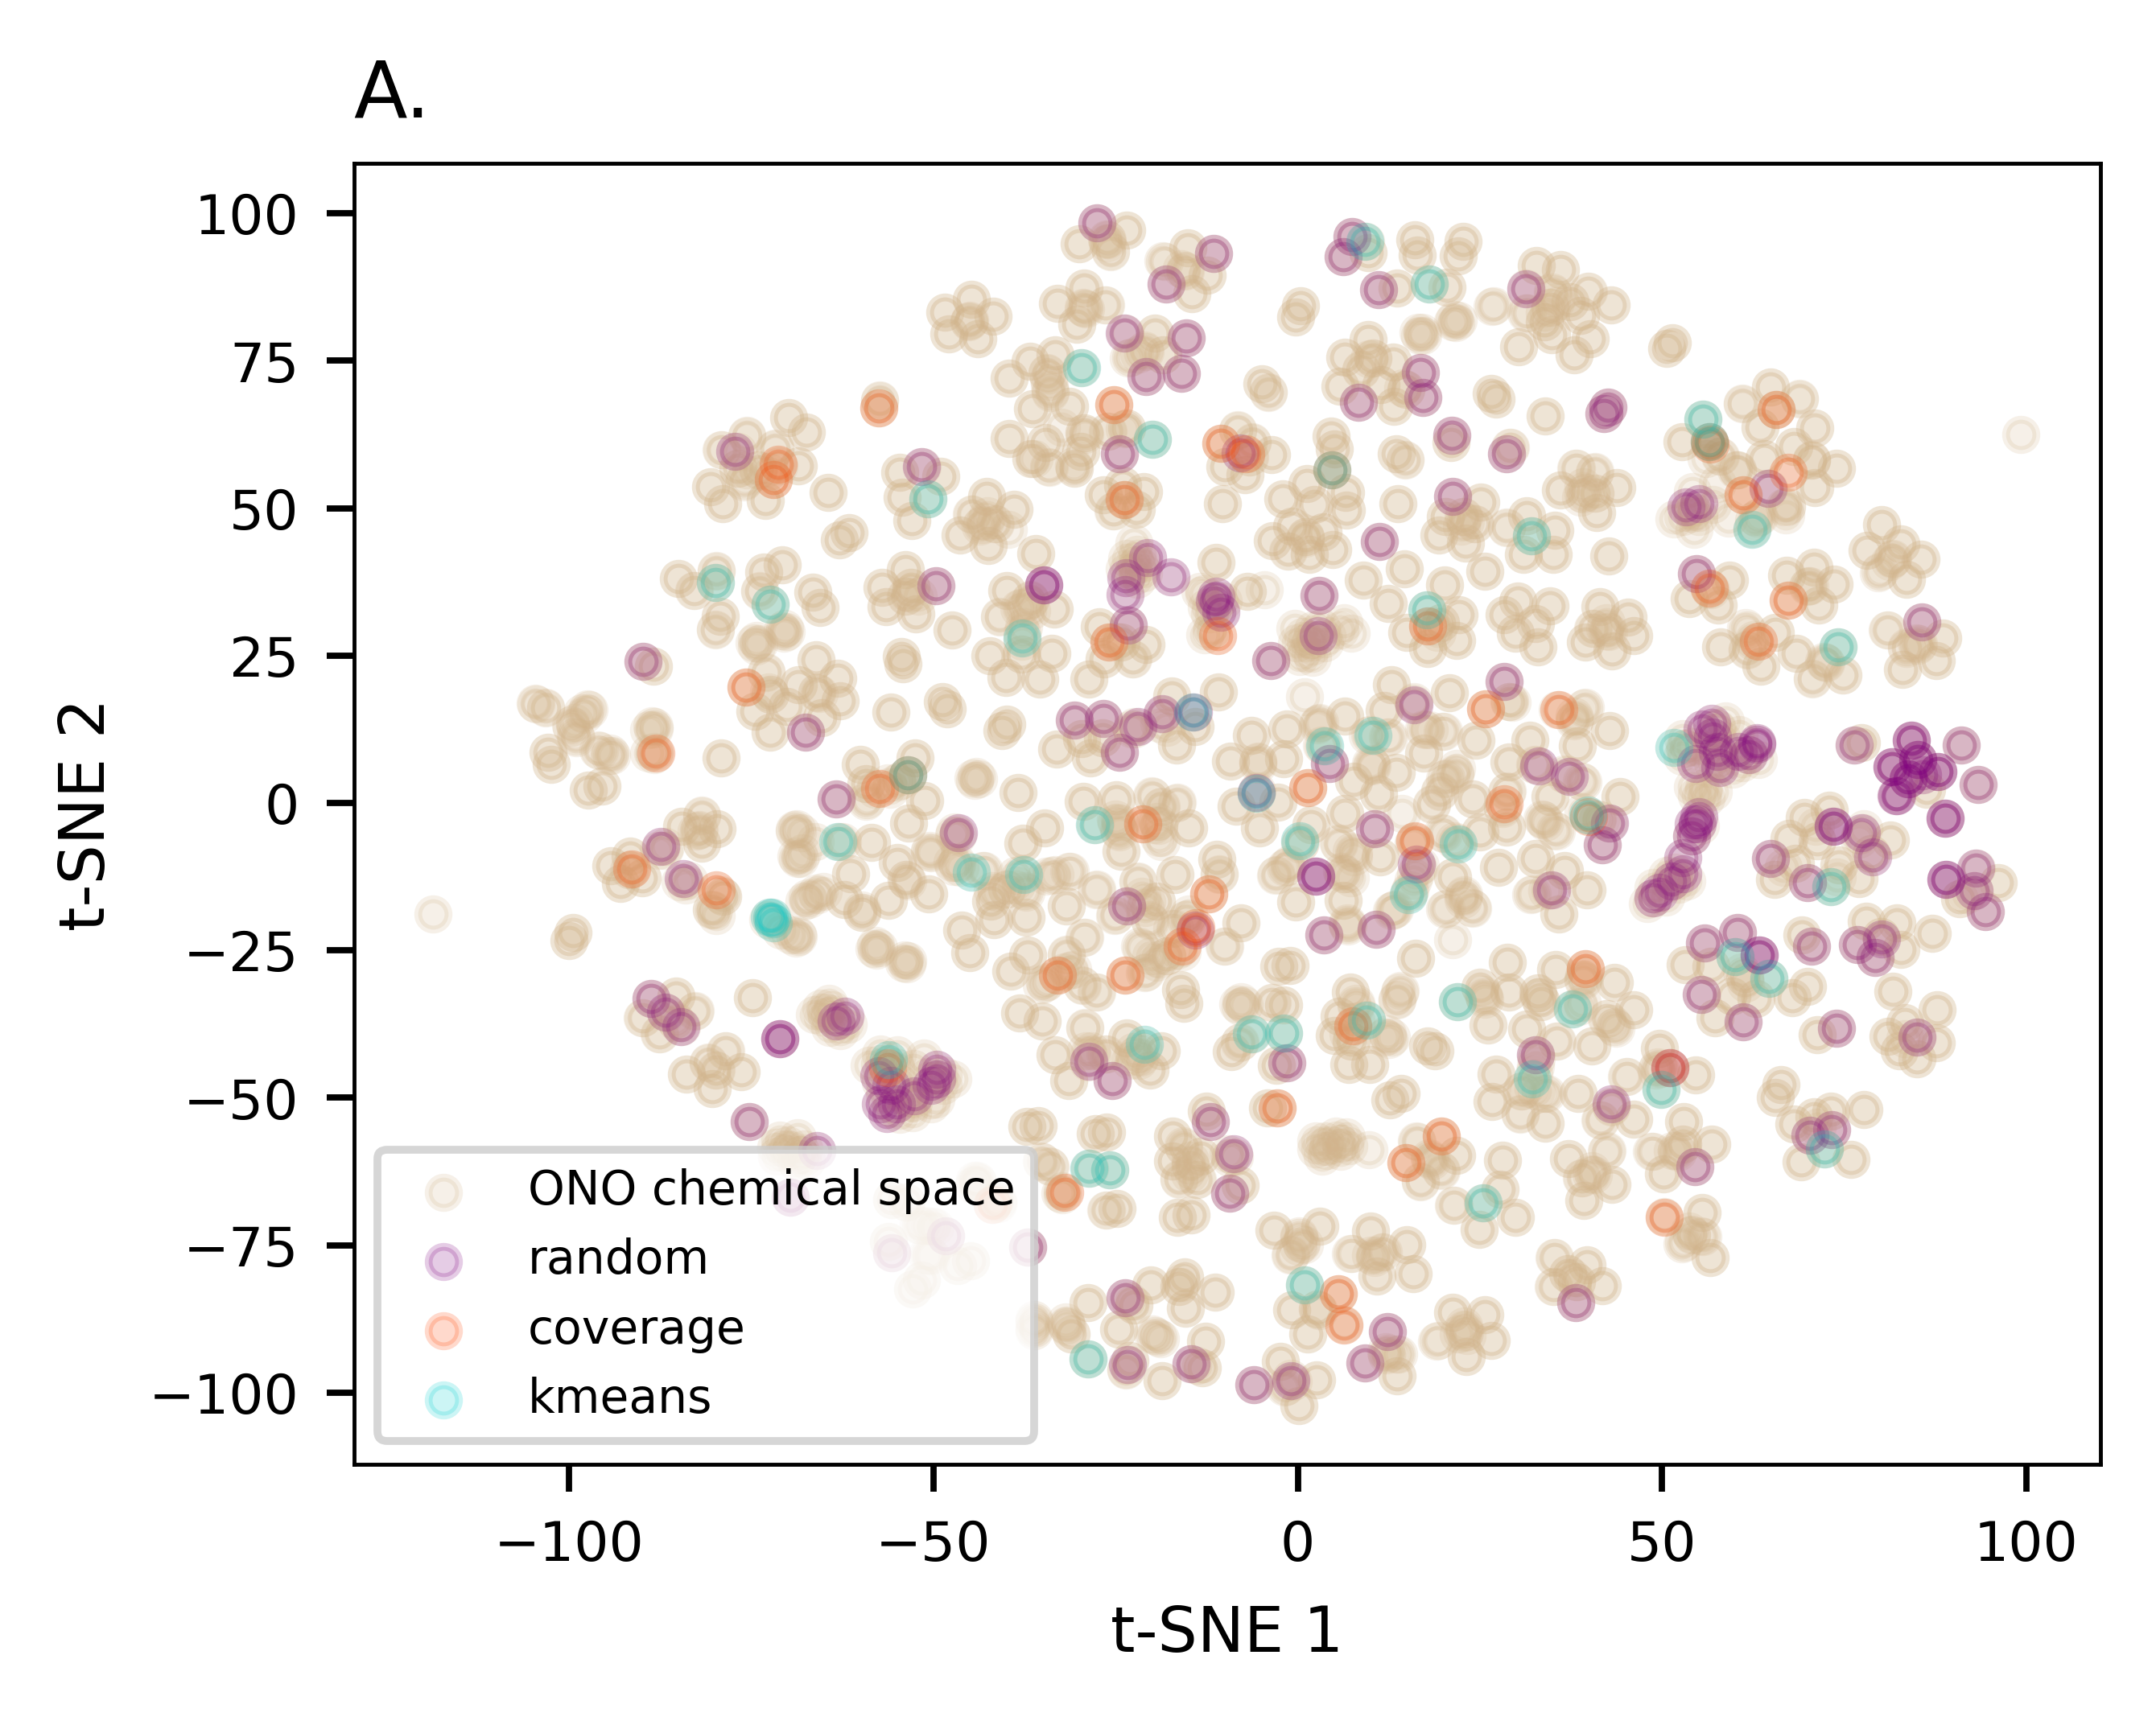

In [102]:
fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot()

ax.scatter(X_embedded_all[:,0], X_embedded_all[:,1], c = 'tan', s = 15, alpha = 0.2, marker = "o", label = 'ONO chemical space')
ax.scatter(df_X_embedded_random[0], df_X_embedded_random[1], c = 'purple', s = 15, alpha = 0.2, marker = 'o', label = 'random')
ax.scatter(df_X_embedded_coverage[0], df_X_embedded_coverage[1], c = 'orangered', s = 15, alpha = 0.2, marker = 'o', label = 'coverage')
ax.scatter(df_X_embedded_kmeans[0], df_X_embedded_kmeans[1], c = 'darkturquoise', s = 15,  alpha = 0.2, marker = 'o', label = 'kmeans')


plt.legend(loc = 'best', fontsize = 6)
plt.ylabel('t-SNE 2')
plt.xlabel('t-SNE 1')
ax.set_title('A.', loc='left', fontsize =10)
plt.show()

fig.savefig('../results/chemical_space/extended_DB_ONO.svg', format = 'svg', transparent= True, facecolor='white', bbox_inches='tight')


In [ ]:
###### indexes_cluster 

for i in range(len(X_embedded_all)):
    if (-100 < X_embedded_all[i,0] < -78) and (7 < X_embedded_all[i,1] < 48):
        indexes_cluster.append(i)
        
smiles_cluster = df_all_smiles.reset_index().loc[indexes_cluster].set_index("SMILES").index
draw_molecules(smiles_cluster)

In [ ]:
df_X_embedded_cluster = df_X_embedded_all.loc[indexes_cluster]
plt.scatter(df_X_embedded_cluster[0], df_X_embedded_cluster[1])

## Principal component analysis (PCA)

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
PCA_tot = PCA()

In [34]:
X = create_descriptors(df_total.index, "quantum", data = data_Q_tot)
X_ONO = create_descriptors(df_ONO.index, "quantum", data = data_Q_tot)

X_NNN = create_descriptors(df_NNN.index, "quantum", data = data_Q_tot)
X_OCO = create_descriptors(df_OCO.index, "quantum", data = data_Q_tot)

X_triarylboranes = create_descriptors(df_triarylboranes.index, "quantum", data = data_Q_tot)

In [35]:
scaler = std_scale.fit(X)
X= scaler.transform(X)
X_ONO = scaler.transform(X_ONO)
X_NNN = scaler.transform(X_NNN)
X_OCO = scaler.transform(X_OCO)
X_triarylboranes = scaler.transform(X_triarylboranes)


In [36]:
PCA_tot.fit(X) #PCA is fitted on all the molecules

PCA()

#### Explainded variance ratio

In [56]:
PCA_tot.explained_variance_ratio_[:7]

array([0.43577485, 0.16041185, 0.10666844, 0.0681402 , 0.0443745 ,
       0.03476868, 0.02612666])

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7')]

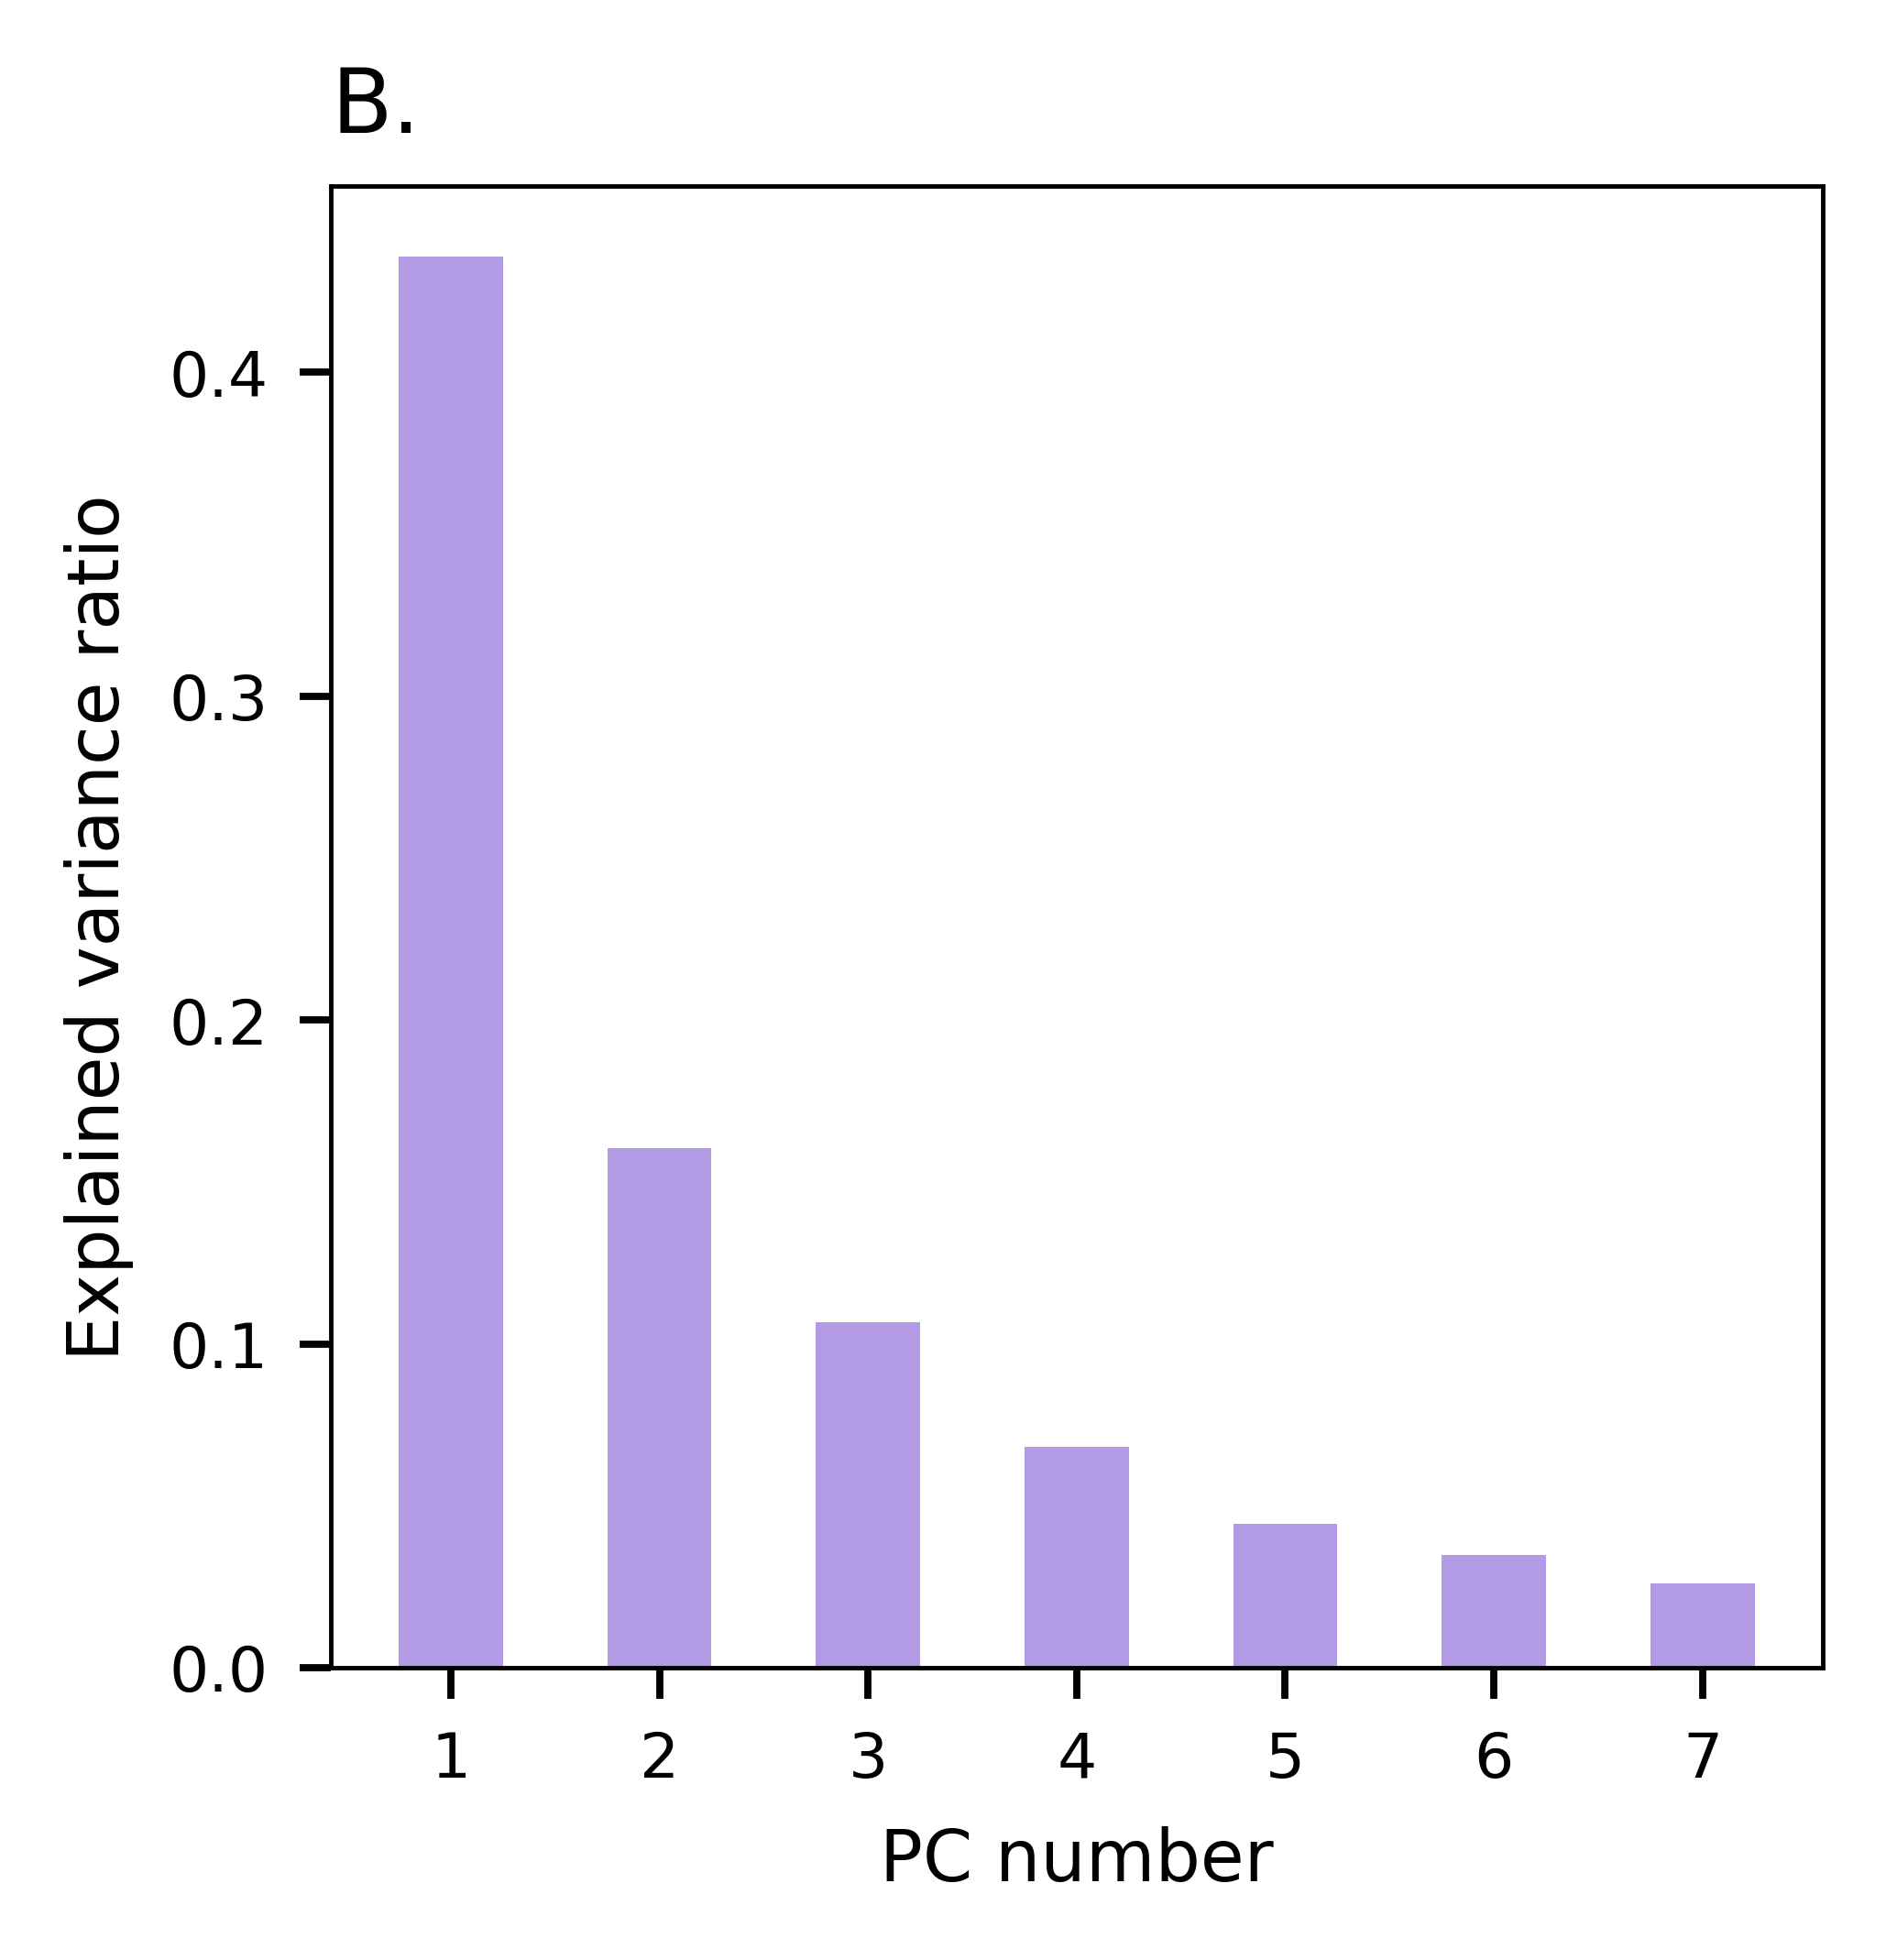

In [57]:
fig = plt.figure(figsize=(3, 3))
ax =  fig.subplots()

plt.bar(range(7),PCA_tot.explained_variance_ratio_[:7], alpha = 0.7, color = "mediumpurple", width = 0.5)

ax.set_xlabel('PC number')

ax.set_ylabel('Explained variance ratio')
plt.title("B.", loc = 'left', size = 10)
ax.set_xticks(list(range(0,7)))
ax.set_xticklabels(list(range(1,8)))

#fig.savefig(f'article/figures/PCA_explained_variance_ratio_quantum.svg', facecolor = 'white', format = 'svg', transparent = True, bbox_inches='tight')

In [37]:
X_PCA_tot = PCA_tot.transform(X)
X_ONO_PCA_tot = PCA_tot.transform(X_ONO)
X_NNN_PCA_tot = PCA_tot.transform(X_NNN)
X_OCO_PCA_tot = PCA_tot.transform(X_OCO)
X_triarylboranes_PCA_tot = PCA_tot.transform(X_triarylboranes)

#### PCA plot

In [49]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

norm = Normalize(vmin = 180, vmax = 610)
mappable = ScalarMappable(norm=norm, cmap='viridis')
colors = mappable.to_rgba(list(df_total.FIA))

C:\Users\Juliette\AppData\Local\Temp\ipykernel_20700\1308055471.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable, label="FIA ($kJ.mol^{-1}$)")


Text(0.0, 1.0, 'A.')

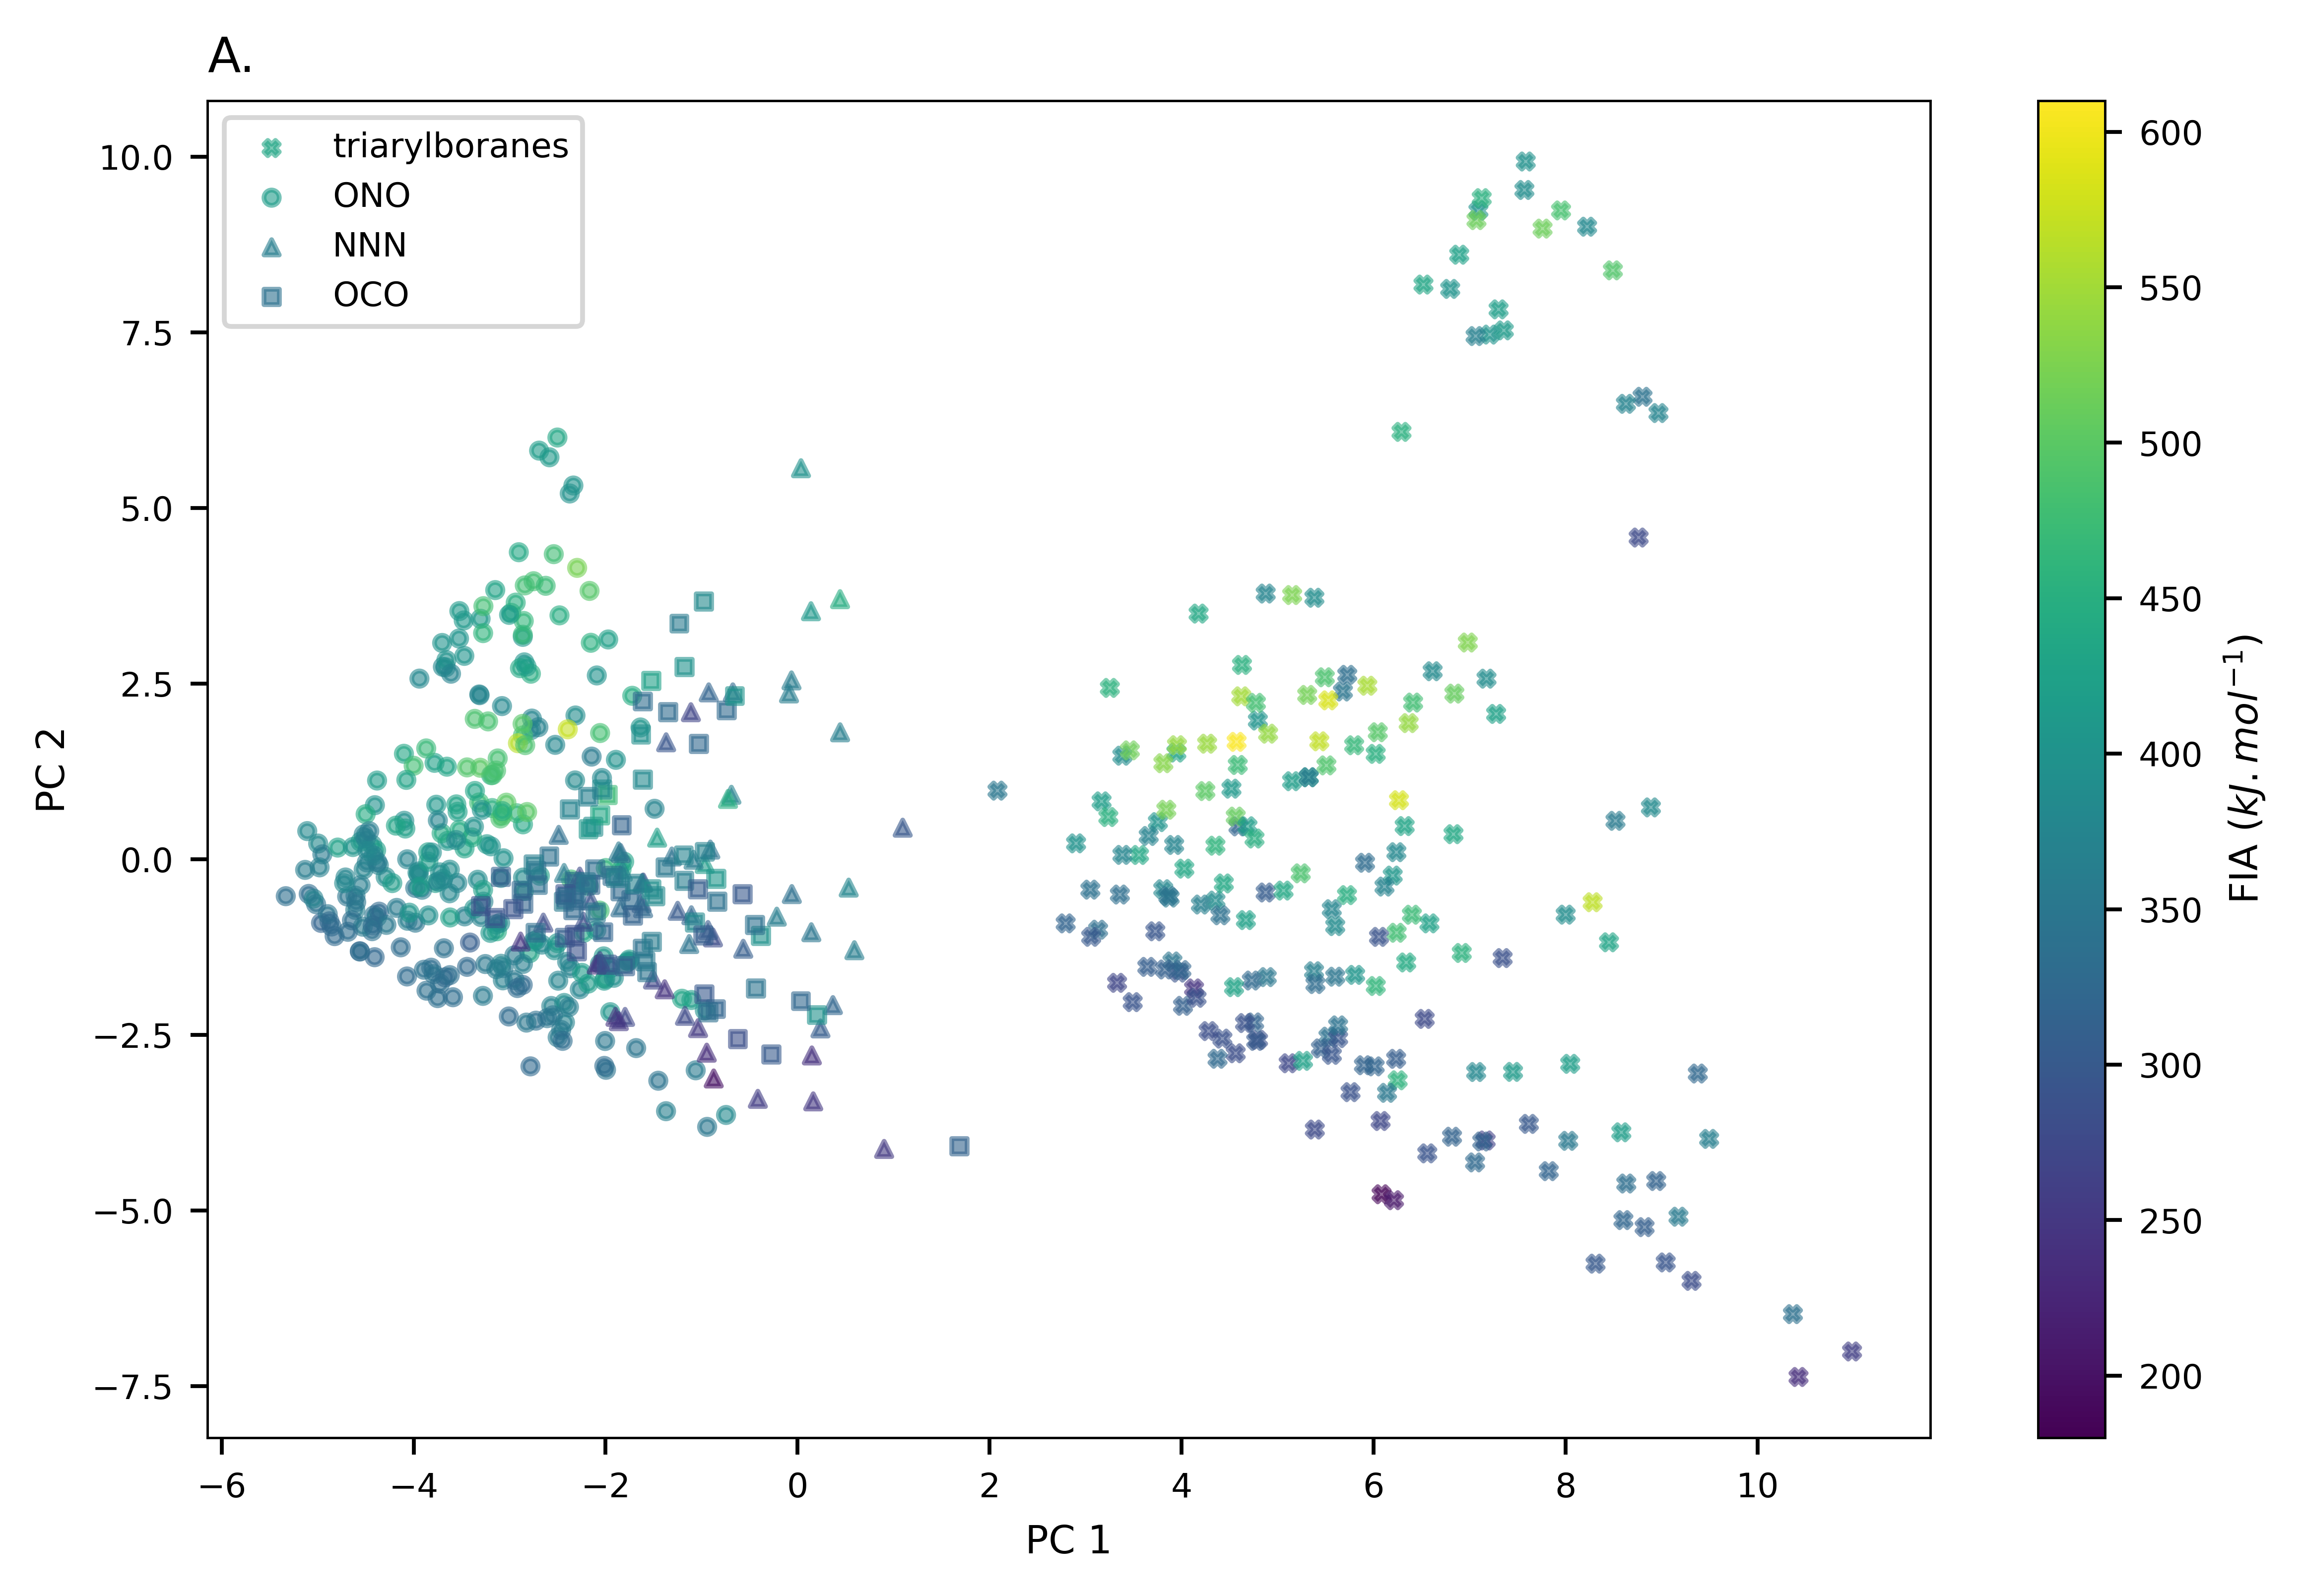

In [53]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(X_triarylboranes_PCA_tot[:,0],X_triarylboranes_PCA_tot[:,1], s = 10, c = mappable.to_rgba(list(df_triarylboranes.FIA)) ,alpha = 0.6, marker = "X", label = "triarylboranes")
plt.scatter(X_ONO_PCA_tot[:,0], X_ONO_PCA_tot[:,1], s= 10, c = mappable.to_rgba(list(df_ONO.FIA)), alpha = 0.6, marker = "o", label = "ONO")
plt.scatter(X_NNN_PCA_tot[:,0], X_NNN_PCA_tot[:,1], s = 10, c = mappable.to_rgba(list(df_NNN.FIA)), alpha = 0.6, marker = "^", label = "NNN")
plt.scatter(X_OCO_PCA_tot[:,0],X_OCO_PCA_tot[:,1], s = 10, c = mappable.to_rgba(list(df_OCO.FIA)),alpha = 0.6, marker = "s", label = "OCO")


plt.colorbar(mappable, label="FIA ($kJ.mol^{-1}$)")
plt.legend(fontsize = 7)
plt.ylabel('PC 2')
plt.xlabel('PC 1')
plt.title("A.", loc = 'left', size = 10)

#fig.savefig(f'article/figures/PCA_quantum.svg', facecolor = 'white', format = 'svg', transparent = False, bbox_inches='tight')

### PCA decomposition

In [59]:
pc1 = [0 for i in range(len(X_PCA_tot[0,:]))]
pc1[0]= 1
inverse_pc1 = PCA_tot.inverse_transform(pc1)

pc2 = [0 for i in range(len(X_PCA_tot[0,:]))]
pc2[1]= 1
inverse_pc2 = PCA_tot.inverse_transform(pc2)

In [60]:
features_names = get_names('quantum')

Text(0.0, 1.0, 'C.')

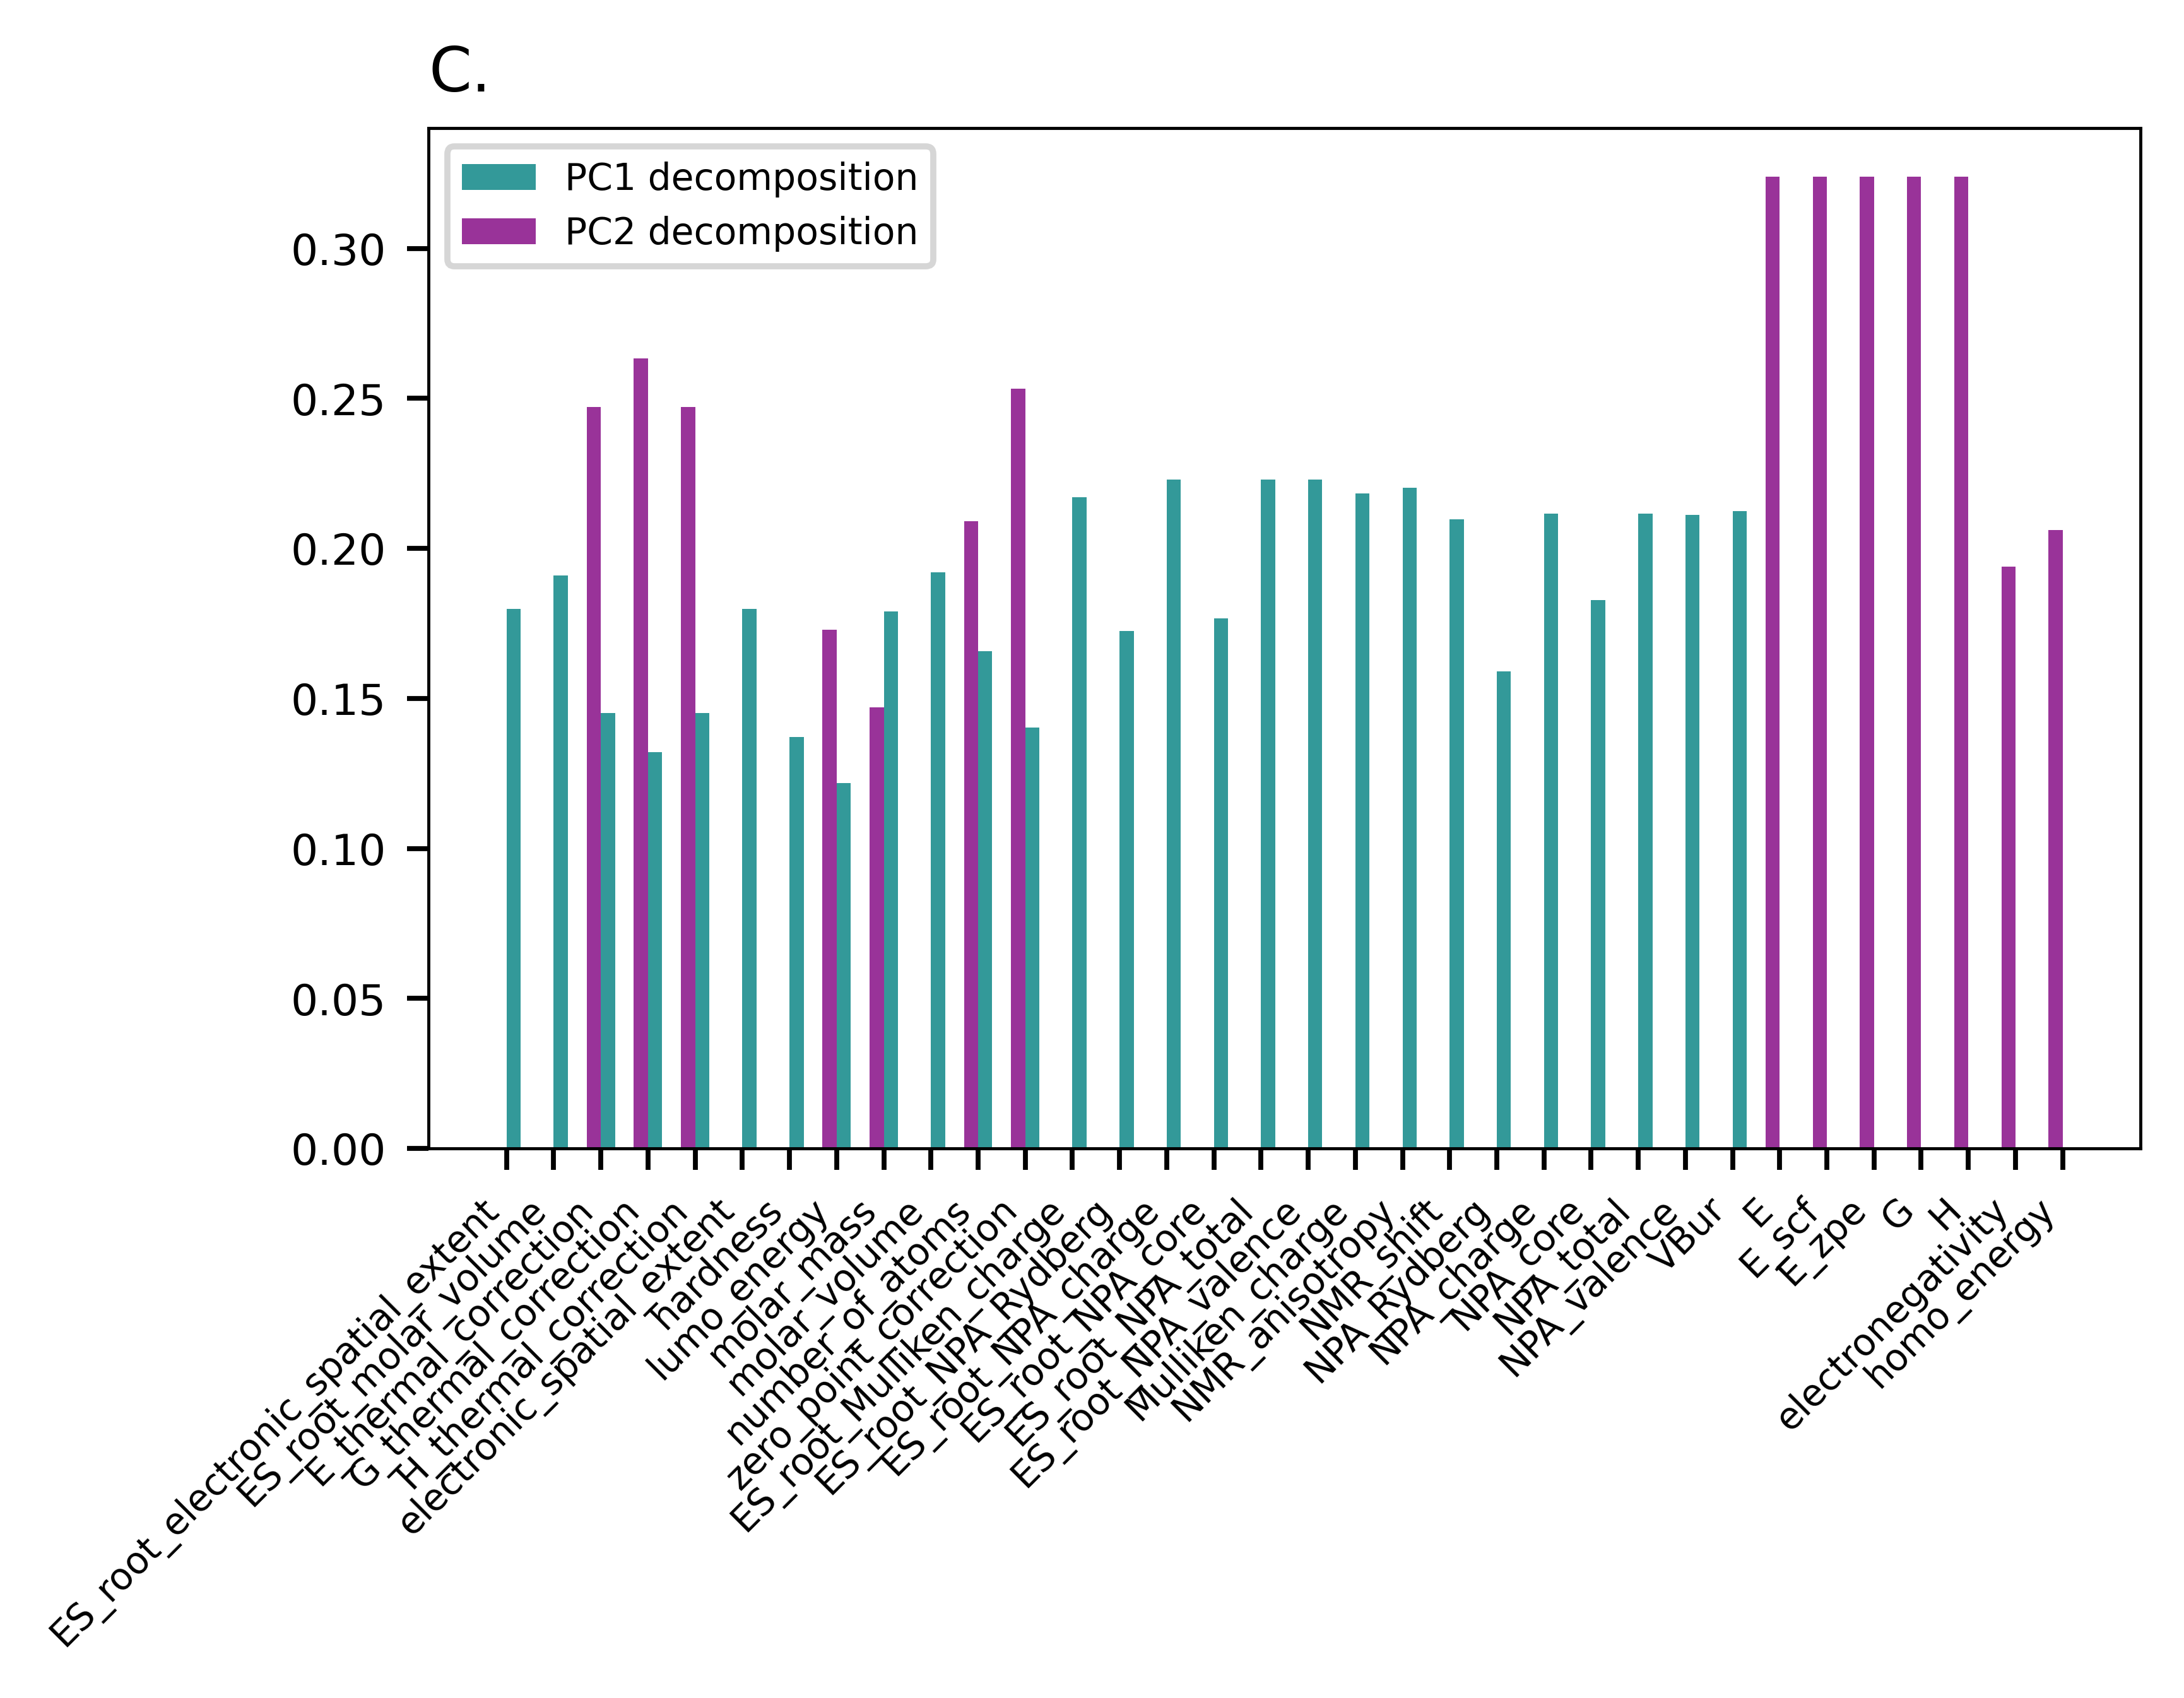

In [61]:
fig = plt.figure(figsize=(5, 3))

decomp_PC1 = {}
for i,j in enumerate(inverse_pc1):
    if abs(j) >0.1:
        decomp_PC1[features_names[i]]=abs(j)
        
decomp_PC2 = {}
for i,j in enumerate(inverse_pc2):
    if abs(j) > 0.1:
        decomp_PC2[features_names[i]]=abs(j)
        
plt.bar(decomp_PC1.keys(), decomp_PC1.values(), width = 0.3, align = 'edge', color = 'teal', alpha = 0.8, label="PC1 decomposition")
plt.bar(decomp_PC2.keys(), decomp_PC2.values(), width = -0.3, align = 'edge', color = 'purple', alpha = 0.8,  label = "PC2 decomposition")
plt.legend()
plt.xticks(rotation=45, rotation_mode='default', ha = 'right', size = 6)
plt.title("C.", loc = 'left', size = 10)

## Figure PCA

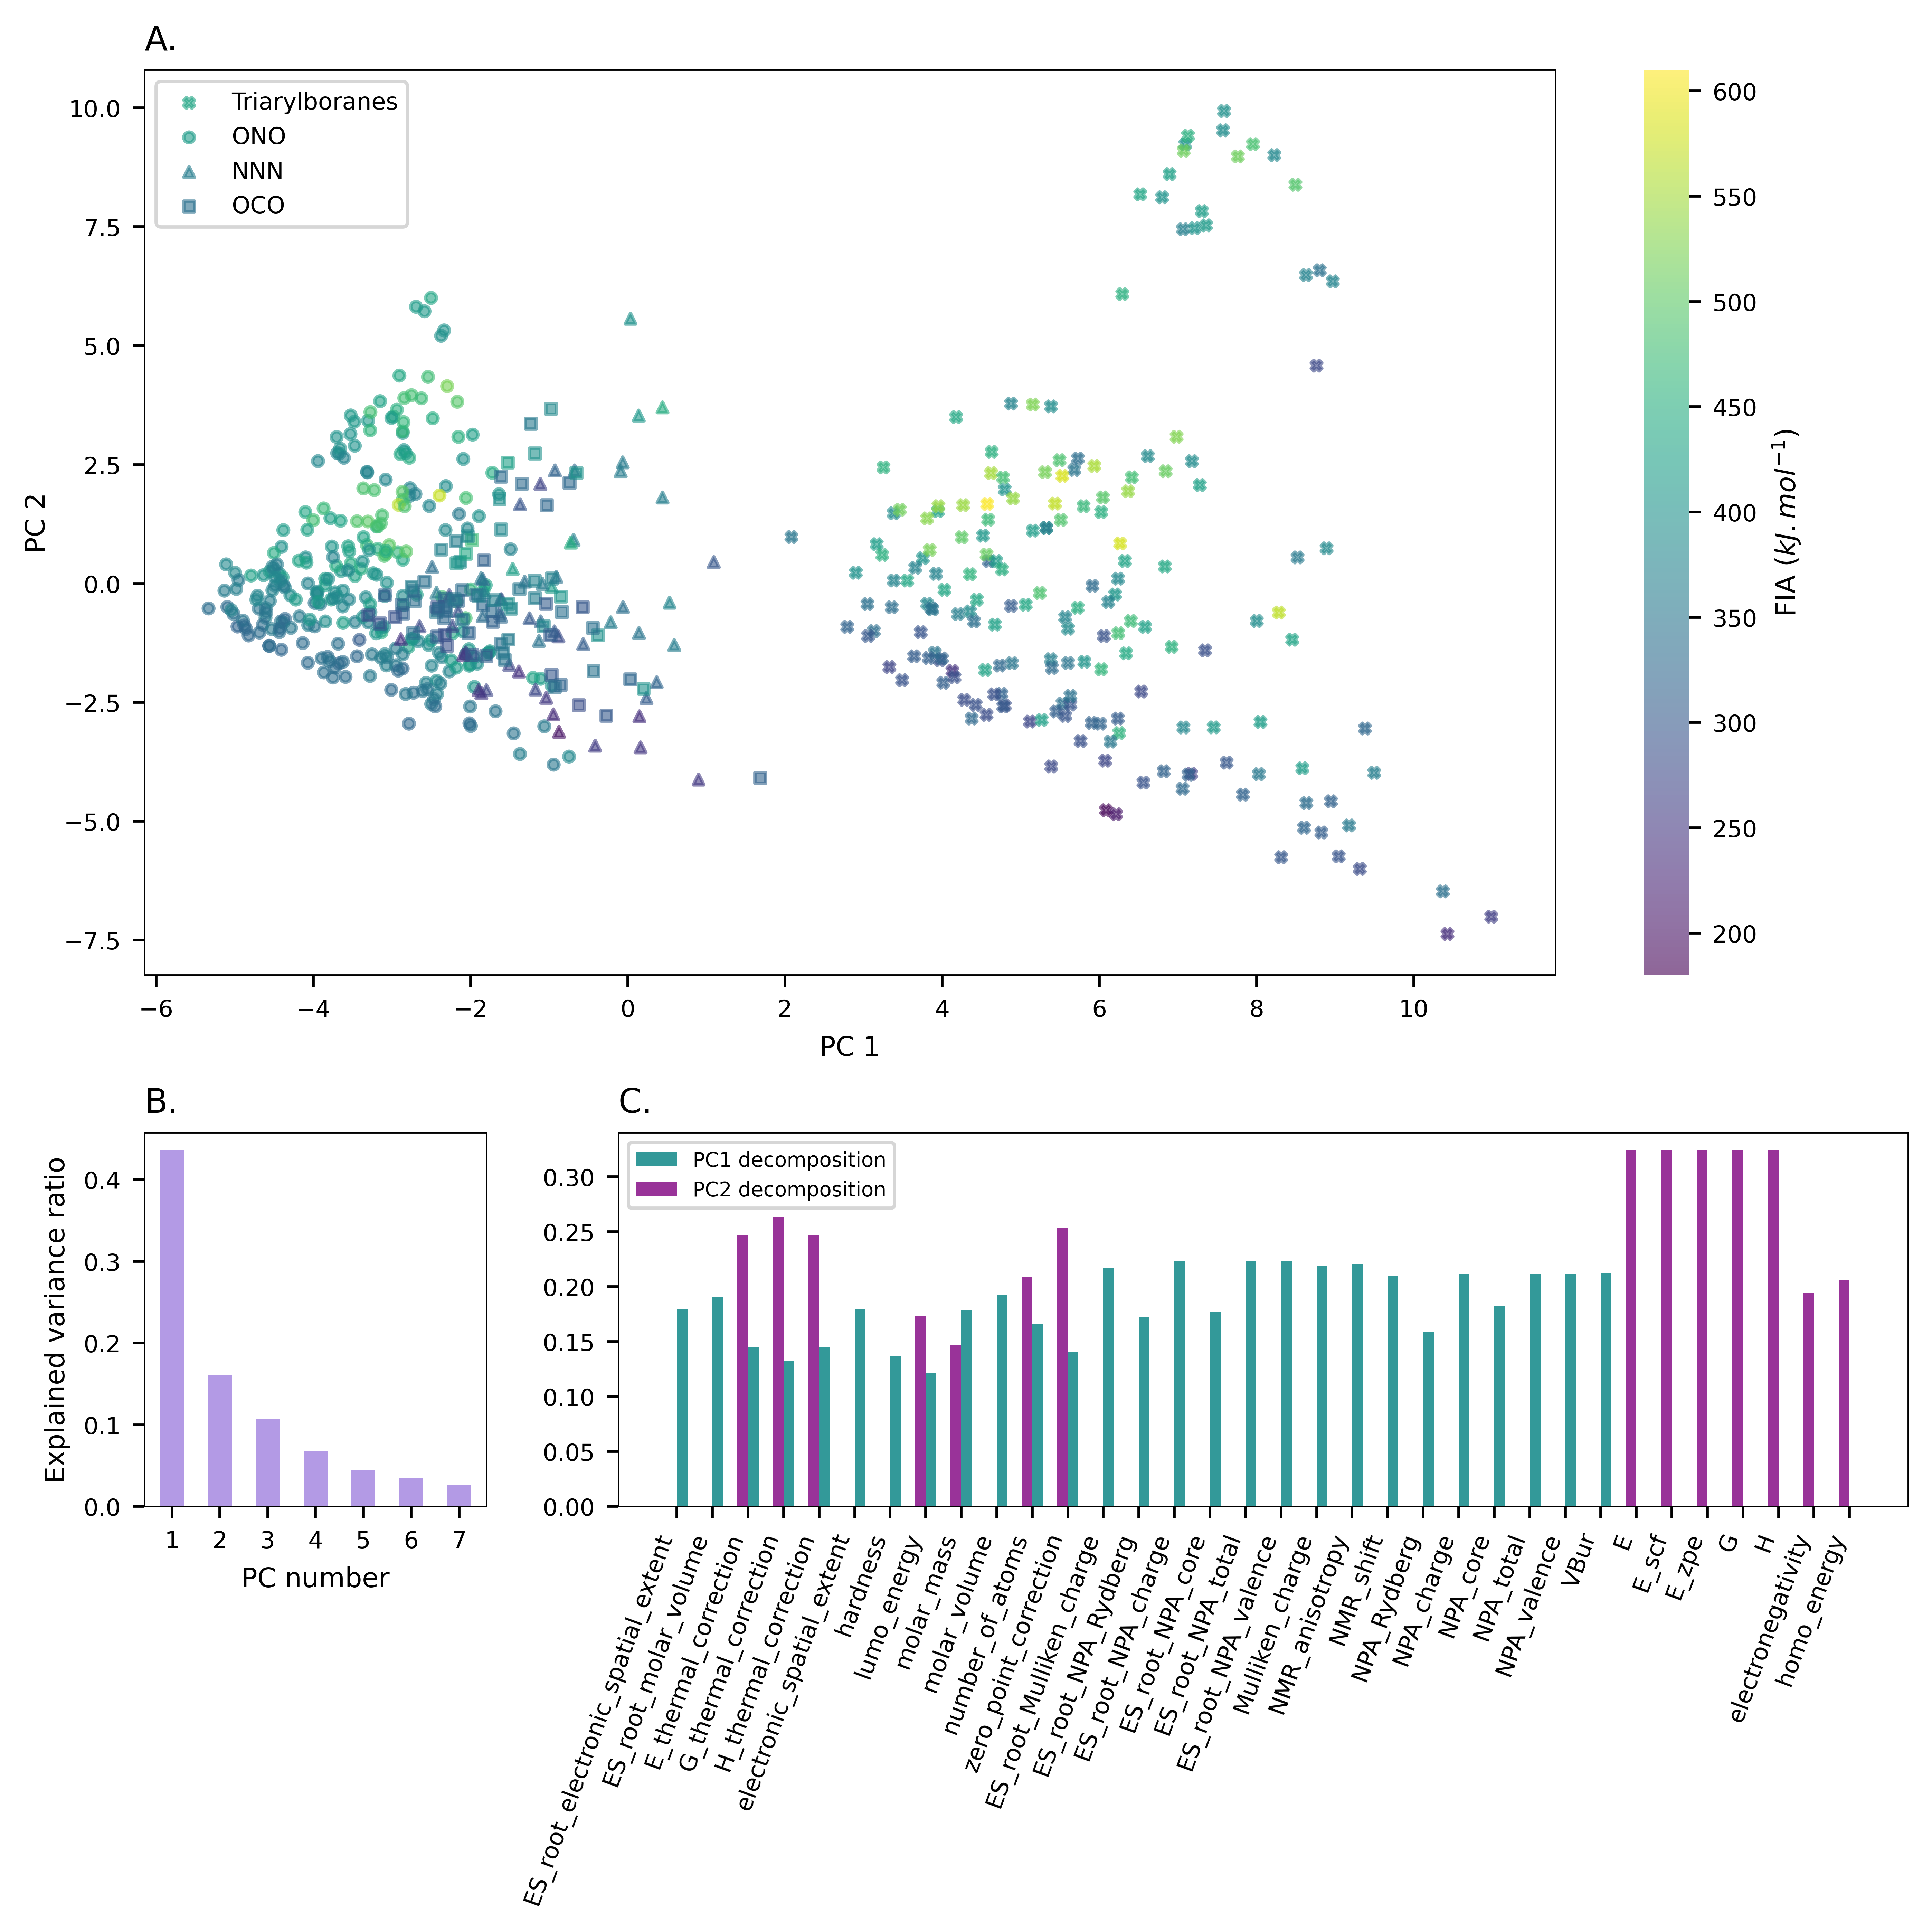

In [68]:
fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=4, rowspan = 2)

ax2 = plt.subplot2grid((3, 4), (2, 0))
ax3 = plt.subplot2grid((3, 4), (2, 1), colspan = 3)

## 1st graph 

ax1.scatter(X_triarylboranes_PCA_tot[:,0],X_triarylboranes_PCA_tot[:,1], s = 10, c = mappable.to_rgba(list(df_triarylboranes.FIA)) ,alpha = 0.6, marker = "X", label = "Triarylboranes")
ax1.scatter(X_ONO_PCA_tot[:,0], X_ONO_PCA_tot[:,1], s= 10, c = mappable.to_rgba(list(df_ONO.FIA)), alpha = 0.6, marker = "o", label = "ONO")
ax1.scatter(X_NNN_PCA_tot[:,0], X_NNN_PCA_tot[:,1], s = 10, c = mappable.to_rgba(list(df_NNN.FIA)), alpha = 0.6, marker = "^", label = "NNN")
ax1.scatter(X_OCO_PCA_tot[:,0],X_OCO_PCA_tot[:,1], s = 10, c = mappable.to_rgba(list(df_OCO.FIA)),alpha = 0.6, marker = "s", label = "OCO")

cbar = fig.colorbar( mappable, ax=ax1, alpha = 0.6)
cbar.set_label("FIA ($kJ.mol^{-1}$)")
cbar.outline.set_visible(False)

#plt.colorbar(label="FIA (kJ/mol)")
ax1.legend(fontsize = 7)
ax1.set_ylabel('PC 2')
ax1.set_xlabel('PC 1')
ax1.set_title("A.", loc = 'left', size = 10)

## 2nd graph

ax2.bar(range(7),PCA_tot.explained_variance_ratio_[:7], alpha = 0.7, color = "mediumpurple", width = 0.5)

ax2.set_xlabel('PC number')

ax2.set_ylabel('Explained variance ratio')
ax2.set_title("B.", loc = 'left', size = 10)
ax2.set_xticks(list(range(0,7)))
ax2.set_xticklabels(list(range(1,8)))

## 3rd graph

ax3.bar(decomp_PC1.keys(), decomp_PC1.values(), width = 0.3, align = 'edge', color = 'teal', alpha = 0.8, label="PC1 decomposition")
ax3.bar(decomp_PC2.keys(), decomp_PC2.values(), width = -0.3, align = 'edge', color = 'purple', alpha = 0.8,  label = "PC2 decomposition")
ax3.legend()
ax3.set_title("C.", loc = 'left', size = 10)
plt.xticks(rotation=70, rotation_mode='default', ha = 'right', size = 7)


plt.tight_layout()

fig.savefig(f'../results/interpretability/quantum_descriptors/PCA_quantum_analysis.png', facecolor = 'white', format = 'png', transparent = False, bbox_inches='tight')

### Triarylboranes and Hammett-extended descriptors

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,3))

df = df_meta_para

sc1 = axs[0].scatter(df["σp"], df["σm"], s =15, c = df.FIA, alpha = 0.5, zorder=4)
axs[0].axhline(y=0, color = 'gray', zorder=1)
axs[0].axvline(x=0, color = 'gray', zorder=1)

axs[0].set_xlabel("$\sigma_{para}$", fontsize = 9)
axs[0].set_ylabel("$\sigma_{meta}$", fontsize = 9)

axs[0].set_title('A.', loc = 'left', fontsize = 10)

df = df_X_triaryl

sc2 = axs[1].scatter(df["σp"], df["σm"], s =15, c = df.FIA, alpha = 0.5, zorder=4)
axs[1].axhline(y=0, color = 'gray', zorder=1)
axs[1].axvline(x=0, color = 'gray', zorder=1)


axs[1].set_xlabel("$\sigma_{para}$", fontsize = 9)
axs[1].set_ylabel("$\sigma_{meta}$",  fontsize = 9)
axs[1].set_title('B.', loc = 'left', fontsize =10)

cbar = fig.colorbar(sc2, ax = axs, label="FIA (kJ/mol)")

fig.savefig('article/figures/hammett_descriptors.png', format = 'png', transparent= True, facecolor='white', bbox_inches='tight')

### Dataframe saving after removing outliers

In [ ]:
## drop molecules with too high FIA values (identified with distribution plot)
df_total = df_total.drop('N#Cc1c(F)c(B(c2c(F)c(C#N)c(C#N)c(C#N)c2F)c2c(F)c(C#N)c(C#N)c(C#N)c2F)c(F)c(C#N)c1C#N')
df_total = df_total.drop('Cc1c(C#N)cc(B(c2cc(C#N)c(C)c(C#N)c2)c2cc(C#N)c(C)c(C#N)c2)cc1C#N')

## far from other distributions in PCA :
df_total = df_total.drop('N#Cc1c2c(cc(C(F)(F)F)c1C(F)(F)F)N1B(O2)Oc2c1cc(C(F)(F)F)c(C(F)(F)F)c2C#N')
df_total = df_total.drop('Cc1c(Br)c(Br)c(B(c2c(Br)c(Br)c(C)c(Br)c2Br)c2c(Br)c(Br)c(C)c(Br)c2Br)c(Br)c1Br')

## tail of distribution for triarylboranes and outlier in PCA : 
df_total = df_total.drop('CC(C)(C)c1cc(C(C)(C)C)c([N+](=O)[O-])c(B(c2c([N+](=O)[O-])c(C(C)(C)C)cc(C(C)(C)C)c2[N+](=O)[O-])c2c([N+](=O)[O-])c(C(C)(C)C)cc(C(C)(C)C)c2[N+](=O)[O-])c1[N+](=O)[O-]')

In [64]:
df_total.to_csv('../tables/data/df_total.csv')